# DKASC_爱丽丝泉_光伏预测

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import keras
import catboost as cb
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement = True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
config.gpu_options.allow_growth = True
sess0 = tf.InteractiveSession(config = config)

In [3]:
print(os.getcwd()) # 打印当前工作目录

E:\graduation project\DKASC, Alice Springs


In [4]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '101-Site_DKA-WeatherStation',
 '96-Site_DKA-MasterMeter1',
 'Alice_Springs_2016-2020',
 'Alice_Springs第三版A.ipynb',
 'Alice_Springs第三版B-LSTM.ipynb',
 'Alice_Springs第三版B-NN无归一化.ipynb',
 'Alice_Springs第三版B.ipynb',
 'Alice_Springs第三版备份.ipynb',
 'Dataset',
 'Predict',
 'Program backups',
 'temp',
 '笔记.ipynb']

In [5]:
os.chdir("./Dataset/")

In [6]:
os.listdir()

['testdata.csv',
 'test_1A.csv',
 'traindata.csv',
 'train_1A.csv',
 '测试集8个站点.csv',
 '训练集8个站点.csv']

In [7]:
train = pd.read_csv('train_1A.csv')
test = pd.read_csv('test_1A.csv')

In [8]:
#查看输入数据维度
print(train.shape)
print(test.shape)

(141428, 14)
(26091, 14)


In [9]:
train.head(5)

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,302.882996,3.6,65.268631,59.278999,0.318600
1,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,246.312622,3.6,72.546944,63.134579,0.328800
2,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,305.089630,3.6,76.711456,65.430550,0.334200
3,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,259.662933,3.6,80.445709,66.812790,0.333133
4,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,186.634705,3.6,83.035919,69.054459,0.332400


In [10]:
test.head(5)

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2020,1,1,0,0,29.685360,21.727171,1.360221,1.191879,33.216167,0.0,2.958199,0.524153,0.0
1,2020,1,1,0,5,29.559967,21.878902,1.532208,1.460944,33.254341,0.0,3.288470,0.764565,0.0
2,2020,1,1,0,10,29.530006,21.859453,1.186835,1.118219,33.302616,0.0,3.253541,0.725652,0.0
3,2020,1,1,0,15,29.474438,21.897285,1.017349,0.824890,33.337837,0.0,3.260514,0.706365,0.0
4,2020,1,1,0,20,29.365288,22.085625,1.323369,1.175776,33.375069,0.0,3.148183,0.694154,0.0


# 数据预处理训练集去异常值

In [11]:
#使用df.isnull().sum()来获得与行数None和NaN值。
train.isnull().sum()

Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [12]:
test.isnull().sum()

Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [13]:
# #训练集去掉全是空值的行和列    #axis=0, how='any', thresh=None, subset=None, inplace=False)
# # detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# # for i in detectioncolumns:
# train.dropna(axis="index",how='any' , inplace=True)  #删除掉全是空值的行
# # train.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列


# test.dropna(axis="index", how='any', inplace=True)  #删除掉全是空值的行
# # test.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列

In [14]:
# #填补缺失值为均值
# #train.ffill({"RGT":train['RGT'].mean()})
# detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# for i in detectioncolumns:
#     replace_NA=train[i].mean()
#     train[i].fillna(replace_NA,inplace=True)
# #去除测试集空值
# for i in detectioncolumns:
#     replace_NA=test[i].mean()
#     test[i].fillna(replace_NA,inplace=True)


In [15]:
train.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [16]:
test.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [17]:
train.head()

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,302.882996,3.6,65.268631,59.278999,0.318600
1,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,246.312622,3.6,72.546944,63.134579,0.328800
2,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,305.089630,3.6,76.711456,65.430550,0.334200
3,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,259.662933,3.6,80.445709,66.812790,0.333133
4,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,186.634705,3.6,83.035919,69.054459,0.332400


In [18]:
test.head()

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2020,1,1,0,0,29.685360,21.727171,1.360221,1.191879,33.216167,0.0,2.958199,0.524153,0.0
1,2020,1,1,0,5,29.559967,21.878902,1.532208,1.460944,33.254341,0.0,3.288470,0.764565,0.0
2,2020,1,1,0,10,29.530006,21.859453,1.186835,1.118219,33.302616,0.0,3.253541,0.725652,0.0
3,2020,1,1,0,15,29.474438,21.897285,1.017349,0.824890,33.337837,0.0,3.260514,0.706365,0.0
4,2020,1,1,0,20,29.365288,22.085625,1.323369,1.175776,33.375069,0.0,3.148183,0.694154,0.0


# keras模型训练

准备数据

In [19]:
train1=train[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']]
print("查看训练集\n",train1.head())
test1=test[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']]
print("查看测试集\n",test.head())

查看训练集
    Year  Month  Day  Hour  Minutes        WTC        WRH        GHR  \
0  2018      1   19    18       30  26.243799  50.889774  71.416481   
1  2018      1   19    18       35  26.641783  49.539795  77.177094   
2  2018      1   19    18       40  26.654078  53.414265  78.373489   
3  2018      1   19    18       45  26.439108  55.582245  78.022881   
4  2018      1   19    18       50  26.479477  56.173820  82.106972   

         DHR          WD  WDR        RGT        RDT  1A Trina_power  
0  67.523544  302.882996  3.6  65.268631  59.278999        0.318600  
1  71.776718  246.312622  3.6  72.546944  63.134579        0.328800  
2  69.008316  305.089630  3.6  76.711456  65.430550        0.334200  
3  67.560181  259.662933  3.6  80.445709  66.812790        0.333133  
4  73.004196  186.634705  3.6  83.035919  69.054459        0.332400  
查看测试集
    Year  Month  Day  Hour  Minutes        WTC        WRH       GHR       DHR  \
0  2020      1    1     0        0  29.685360  21.727171  1

############################# 训练、测试数据 选择 ###################################

In [20]:
######## 训练集 ########
train1 = train1.values
train1 = train1.astype('float32')     # 将整型变为float

######## 测试集 ########
test1 = test1.values
test1 = test1.astype('float32')# 将整型变为float

##
train1 = np.array(train1,dtype='float32')
test1 = np.array(test1,dtype='float32')
##

# # 归一化训练集 #
# scaler = MinMaxScaler(feature_range=(0, 1))# 数据处理，归一化至0~1之间
# train1 = scaler.fit_transform(train1)


# # 归一化测试集 #
# scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
# test1 = scaler.fit_transform(test1)

######随机选择，打乱顺序########
inds = np.arange(train1.shape[0])
random.shuffle(inds)
train1_inds = inds[0:int(train1.shape[0]*0.8)]
eval1_inds = inds[int(train1.shape[0]*0.8):train1.shape[0]]


train_x, train_y = train1[train1_inds,:-1], train1[train1_inds,-1:]
eval_x,eval_y = train1[eval1_inds,:-1], train1[eval1_inds,-1:]
test_x, test_y = test1[:, :-1], test1[:,-1:]

In [21]:
print(train1)

[[2.0180000e+03 1.0000000e+00 1.9000000e+01 ... 6.5268631e+01
  5.9278999e+01 3.1860000e-01]
 [2.0180000e+03 1.0000000e+00 1.9000000e+01 ... 7.2546944e+01
  6.3134579e+01 3.2879999e-01]
 [2.0180000e+03 1.0000000e+00 1.9000000e+01 ... 7.6711456e+01
  6.5430550e+01 3.3420002e-01]
 ...
 [2.0190000e+03 1.2000000e+01 3.1000000e+01 ... 2.8704400e+00
  4.9333772e-01 0.0000000e+00]
 [2.0190000e+03 1.2000000e+01 3.1000000e+01 ... 2.5691125e+00
  3.4133789e-01 0.0000000e+00]
 [2.0190000e+03 1.2000000e+01 3.1000000e+01 ... 2.8219686e+00
  3.9141777e-01 0.0000000e+00]]


In [22]:
print(train_x)

[[2.01800000e+03 4.00000000e+00 2.00000000e+00 ... 0.00000000e+00
  3.07938313e+00 3.80365133e-01]
 [2.01800000e+03 7.00000000e+00 8.00000000e+00 ... 0.00000000e+00
  7.81773315e+02 7.22691803e+01]
 [2.01800000e+03 1.10000000e+01 2.50000000e+01 ... 0.00000000e+00
  1.07929175e+03 8.41140976e+01]
 ...
 [2.01800000e+03 8.00000000e+00 5.00000000e+00 ... 0.00000000e+00
  1.70627518e+02 3.29131279e+01]
 [2.01900000e+03 6.00000000e+00 1.30000000e+01 ... 0.00000000e+00
  1.50494795e+01 1.02396736e+01]
 [2.01800000e+03 6.00000000e+00 1.40000000e+01 ... 0.00000000e+00
  3.40048647e+00 1.63801885e+00]]


In [23]:
print(train_y)

[[0.       ]
 [3.1931999]
 [7.7440004]
 ...
 [2.4434333]
 [0.       ]
 [0.       ]]


In [24]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(113142, 13)
(113142, 1)
(26091, 13)
(26091, 1)


# Model1

In [25]:
model1 = Sequential()
model1.add(Dense(units=64, input_shape = (13,),activation='softmax',name='layer1'))
model1.add(Dense(units=64,name='layer2'))
model1.add(Dense(units=16,name='layer3'))
model1.add(Dense(units=8,name='layer4'))
model1.add(Dense(units=1,name='layer5'))
model1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mae'])
history = model1.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000,verbose=1)
######################################################################
#######################################################################

Train on 113142 samples, validate on 28286 samples
Epoch 1/50
113142/113142 [==============================] - 2s - loss: 1.6355 - mean_absolute_error: 0.7046 - val_loss: 0.8781 - val_mean_absolute_error: 0.5626
Epoch 2/50
113142/113142 [==============================] - 1s - loss: 0.7893 - mean_absolute_error: 0.4913 - val_loss: 0.7767 - val_mean_absolute_error: 0.5685
Epoch 3/50
113142/113142 [==============================] - 1s - loss: 0.7084 - mean_absolute_error: 0.4636 - val_loss: 0.6947 - val_mean_absolute_error: 0.4520
Epoch 4/50
113142/113142 [==============================] - 1s - loss: 0.6826 - mean_absolute_error: 0.4525 - val_loss: 0.8146 - val_mean_absolute_error: 0.4774
Epoch 5/50
113142/113142 [==============================] - 1s - loss: 0.6719 - mean_absolute_error: 0.4473 - val_loss: 0.6745 - val_mean_absolute_error: 0.4599
Epoch 6/50
113142/113142 [==============================] - 1s - loss: 0.6686 - mean_absolute_error: 0.4427 - val_loss: 0.6633 - val_mean_absolu

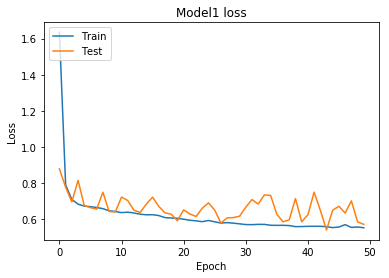

In [26]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
# # 绘制训练 & 验证的准确率值
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

#  Model2   Dense with activation

In [28]:
model2 = Sequential()
model2.add(Dense(units=64, input_shape = (13,),activation='sigmoid',name='layer1'))
model2.add(Dense(units=32, activation='sigmoid',name='layer2'))
model2.add(Dense(units=16,name='layer3',activation='sigmoid'))
model2.add(Dense(units=8,name='layer4',activation='sigmoid'))
model2.add(Dense(units=1,name='layer5'))
# model2.add(Dense(units=4,name='layer5',activation='sigmoid'))
# model2.add(Dense(units=1,name='layer6'))
model2.compile(loss='mean_absolute_error',
              optimizer='rmsprop',
              metrics=['mae'])
history=model2.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000)

#########################################################################


Train on 113142 samples, validate on 28286 samples
Epoch 1/50
113142/113142 [==============================] - 1s - loss: 1.7687 - mean_absolute_error: 1.7687 - val_loss: 1.5847 - val_mean_absolute_error: 1.5847
Epoch 2/50
113142/113142 [==============================] - 0s - loss: 1.3231 - mean_absolute_error: 1.3231 - val_loss: 1.1444 - val_mean_absolute_error: 1.1444
Epoch 3/50
113142/113142 [==============================] - 0s - loss: 0.9547 - mean_absolute_error: 0.9547 - val_loss: 0.8289 - val_mean_absolute_error: 0.8289
Epoch 4/50
113142/113142 [==============================] - 0s - loss: 0.6949 - mean_absolute_error: 0.6949 - val_loss: 0.5996 - val_mean_absolute_error: 0.5996
Epoch 5/50
113142/113142 [==============================] - 0s - loss: 0.5406 - mean_absolute_error: 0.5406 - val_loss: 0.5148 - val_mean_absolute_error: 0.5148
Epoch 6/50
113142/113142 [==============================] - 0s - loss: 0.5051 - mean_absolute_error: 0.5051 - val_loss: 0.5083 - val_mean_absolu

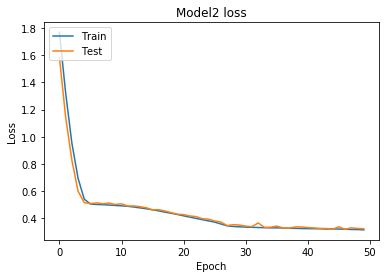

In [29]:
########################################################################
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# dense_model3 with activation,bias

In [30]:
model3 = Sequential()
model3.add(Dense(units=64, input_shape = (13,),activation='sigmoid',name='layer1',use_bias = True))
model3.add(Dense(units=32,activation='sigmoid',name='layer2',use_bias = True))
model3.add(Dense(units=16,name='layer3',activation='sigmoid',use_bias = True))
model3.add(Dense(units=8,name='layer4',activation='sigmoid',use_bias = True))
model3.add(Dense(units=1,name='layer5'))
model3.compile(loss='mean_absolute_error',
              optimizer='rmsprop',
              metrics=['mae'])
history=model3.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000)
############################################################################################################

Train on 113142 samples, validate on 28286 samples
Epoch 1/50
113142/113142 [==============================] - 1s - loss: 1.8481 - mean_absolute_error: 1.8481 - val_loss: 1.7929 - val_mean_absolute_error: 1.7929
Epoch 2/50
113142/113142 [==============================] - 0s - loss: 1.6220 - mean_absolute_error: 1.6220 - val_loss: 1.5121 - val_mean_absolute_error: 1.5121
Epoch 3/50
113142/113142 [==============================] - 0s - loss: 1.3352 - mean_absolute_error: 1.3352 - val_loss: 1.2166 - val_mean_absolute_error: 1.2166
Epoch 4/50
113142/113142 [==============================] - 0s - loss: 1.0636 - mean_absolute_error: 1.0636 - val_loss: 0.9487 - val_mean_absolute_error: 0.9487
Epoch 5/50
113142/113142 [==============================] - 0s - loss: 0.8191 - mean_absolute_error: 0.8191 - val_loss: 0.7229 - val_mean_absolute_error: 0.7229
Epoch 6/50
113142/113142 [==============================] - 0s - loss: 0.6203 - mean_absolute_error: 0.6203 - val_loss: 0.5560 - val_mean_absolu

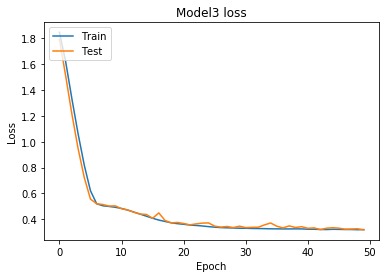

In [31]:
########################################################################
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 结果对比

In [32]:
################预测训练集和测试集####################
######### 模型 1 #########
trainPredictM1 = model1.predict(train_x)
testPredictM1 = model1.predict(test_x)
######### 模型 2 #########
trainPredictM2 = model2.predict(train_x)
testPredictM2 = model2.predict(test_x)
######### 模型 3 ##########
trainPredictM3 = model3.predict(train_x)
testPredictM3 = model3.predict(test_x)

############################## 反归一化 ##############################

###################### 训练集反归一化 #######################
######预测值 模型1 #######
inv_trainPredict1 = concatenate((train_x[:,:],trainPredictM1), axis=1)
# inv_trainPredict1 = scaler.inverse_transform(inv_trainPredict1)
trainPredictM1 = inv_trainPredict1[:,-1:]

######预测值 模型2 #######
inv_trainPredict2 = concatenate((train_x[:,:],trainPredictM2), axis=1)
# inv_trainPredict2 = scaler.inverse_transform(inv_trainPredict2)
trainPredictM2 = inv_trainPredict2[:,-1:]

######训练预测 模型3 #######
inv_trainPredict3 = concatenate((train_x[:,:],trainPredictM3), axis=1)
# inv_trainPredict3 = scaler.inverse_transform(inv_trainPredict3)
trainPredictM3 = inv_trainPredict3[:,-1:]

###### 训练集真实值######
train_y = train_y.reshape((len(train_y), 1))
inv_train = concatenate((train_x[:,:],train_y), axis=1)
# inv_train = scaler.inverse_transform(inv_train)
trainReal = inv_train[:,-1:]


######################## 测试集反归一化 ########################
###### 测试预测模型1 #######
inv_testPredict1 = concatenate((test_x[:,:],testPredictM1), axis=1)
# inv_testPredict1 = scaler.inverse_transform(inv_testPredict1)
testPredictM1 = inv_testPredict1[:,-1:]

###### 测试预测模型2 #######
inv_testPredict2 = concatenate((test_x[:,:],testPredictM2), axis=1)
# inv_testPredict2 = scaler.inverse_transform(inv_testPredict2)
testPredictM2 = inv_testPredict2[:,-1:]

###### 测试预测模型3 #######
inv_testPredict3 = concatenate((test_x[:,:],testPredictM3), axis=1)
# inv_testPredict3 = scaler.inverse_transform(inv_testPredict3)
testPredictM3 = inv_testPredict3[:,-1:]

########测试集真实值############
test_y = test_y.reshape((len(test_y), 1))
inv_test = concatenate((test_x[:,:],test_y), axis=1)
# inv_test = scaler.inverse_transform(inv_test)
testReal = inv_test[:,-1:]

#################### 计算训练集和测试集的平均根方误差####################
### 模型 1
trainScoreM1 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM1[:,0]))
print('Model1 ')
print('Train Score: %.2f RMSE' % (trainScoreM1))
testScoreM1 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM1[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM1))
### 模型 2
trainScoreM2 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM2[:,0]))
print('Model2 ')
print('Train Score: %.2f RMSE' % (trainScoreM2))
testScoreM2 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM2[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM2))
### 模型 3
trainScoreM3 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM3[:,0]))
print('Model3 ')
print('Train Score: %.2f RMSE' % (trainScoreM3))
testScoreM3 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM3[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM3))

Model1 
Train Score: 0.75 RMSE
Test Score: 0.89 RMSE
Model2 
Train Score: 0.79 RMSE
Test Score: 1.02 RMSE
Model3 
Train Score: 0.78 RMSE
Test Score: 0.97 RMSE


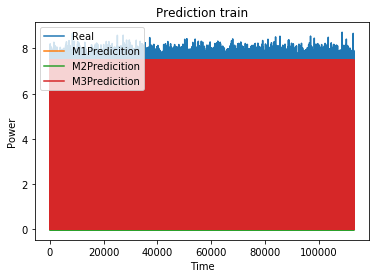

In [33]:
#训练集和测试集 预测结果保存
predict_train_1A = pd.DataFrame(inv_train)
predict_train_1A.columns = ['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']

predict_train_1A['1A_model1_predict'] = trainPredictM1
predict_train_1A['1A_model2_predict'] = trainPredictM2
predict_train_1A['1A_model3_predict'] = trainPredictM3

predict_train_1A.to_csv('../predict/predict_train_1A.csv',index=False)
#真实值和预测值对比图
plt.plot(trainReal,label='Real')
plt.plot(trainPredictM1,label='M1Predicition')
plt.plot(trainPredictM2,label='M2Predicition')
plt.plot(trainPredictM3,label='M3Predicition')

plt.title('Prediction train')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.plot(y_rr_,label='rr')
# plt.plot(y_lasso_,label='lasso')
plt.legend() 

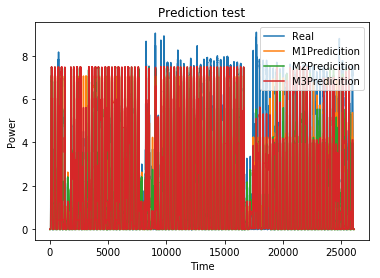

In [34]:
#训练集和测试集 预测结果保存
predict_1A = pd.DataFrame(inv_test)
predict_1A.columns = ['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']

predict_1A['1A_model1_predict'] = testPredictM1
predict_1A['1A_model2_predict'] = testPredictM2
predict_1A['1A_model3_predict'] = testPredictM3

predict_1A.to_csv('../predict/predict_1A.csv',index=False)
#真实值和预测值对比图
plt.plot(testReal,label='Real')
plt.plot(testPredictM1,label='M1Predicition')
plt.plot(testPredictM2,label='M2Predicition')
plt.plot(testPredictM3,label='M3Predicition')

plt.title('Prediction test')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.plot(y_rr_,label='rr')
# plt.plot(y_lasso_,label='lasso')
plt.legend() 

In [35]:
# mse_test=np.sum((test_y - testPredict)**2)/ len(test_y)
# rmse_test=np.sqrt(mse_test)
# print("MSE:",mse_test)
# print("RMSE:",rmse_test)

画出例如2020年1月20号的预测图

In [36]:
predict_1A.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power', '1A_model1_predict',
       '1A_model2_predict', '1A_model3_predict'],
      dtype='object')

In [37]:
# from scipy.interpolate import spline
 
# # T = np.array([6, 7, 8, 9, 10, 11, 12])
# T=Day0120['Hour']
# T=T.values
# # power = np.array([1.53E+03, 5.92E+02, 2.04E+02, 7.24E+01, 2.72E+01, 1.10E+01, 4.70E+00])
# Real=Day0120.set_index('Hour', inplace=False)['1A Trina_power']
# Real=Real.values
# xnew = np.linspace(T.min(),T.max(),300) #300 represents number of points to make between T.min and T.max
 
# power_smooth = spline(T,Real,xnew)
 
# plt.plot(xnew,power_smooth)
# plt.show()

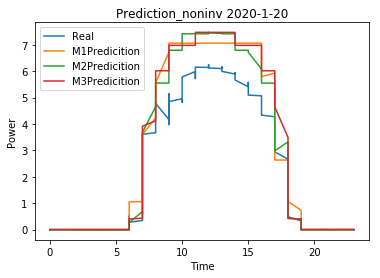

In [38]:
# from scipy.interpolate import spline
predict_1A[["Year","Month","Day","Hour","Minutes"]] = predict_1A[["Year","Month","Day","Hour","Minutes"]].astype("int")

#real_power_day = train_1.groupby('day')
# Day0120 = predict_1A[(predict_1A['Year'] == 2020) & (predict_1A['Month'] == 1) & (predict_1A['Day'] == 20)]
# day200120 = predict_1A.loc[predict_1A['Year'] == '2020',predict_1A['Month'] == '1',predict_1A['day'] == '20',:]
Day0120 = predict_1A.loc[(predict_1A['Year'] == 2020) & (predict_1A['Month'] == 1) & (predict_1A['Day'] == 20),:]
#real_power_day.set_index('time', inplace=False)
Real=Day0120.set_index('Hour', inplace=False)['1A Trina_power']
M1Predict=Day0120.set_index('Hour', inplace=False)['1A_model1_predict']
M2Predict=Day0120.set_index('Hour', inplace=False)['1A_model2_predict']
M3Predict=Day0120.set_index('Hour', inplace=False)['1A_model3_predict']

fig = plt.figure()
plt.plot(Real,label='Real')
plt.plot(M1Predict,label='M1Predicition')
plt.plot(M2Predict,label='M2Predicition')
plt.plot(M3Predict,label='M3Predicition')

plt.title('Prediction_noninv 2020-1-20')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
#ax = fig.add_subplot(1,1,1)
#ax.plot(real_power_day_)
# real_power_day_.plot()
#real_power_day_.set_axis(['00:15:00','06:15:00','12:15:00','18:15:00'])
#real_power_day_